# VASP TiO2 benchmark performance

This notebook compares the performance of the TiO2 benchmark (pure DFT) between ARCHER and ARCHER2 and for VASP compiled with different numerical libraries on ARCHER2.

We compute performance using the maximum time per SCF cycle from all cycles in the output file. The maximum is used as SCF cycles are non-homogeneous in this VASP benchmark with extra work being done in the later SCF cycles. In the full calculation from which this benchmark is extracted, the long SCF cycles make up the majority of the cycles and dominate the runtime.

Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds).

All calculations were performed with VASP 5.4.4.pl2:

- On ARCHER: Intel Compilers 17, FFTW, Intel MKL 17
- On ARCHER2: GCC 10.1.0, FFTW 3.3.8.8, HPE Cray MPICH 8.0.16 and various numerical libraries

## Setup section

Import the required modules and define useful functions.

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [10]:
import sys
sys.path.append('../../../python-modules')

In [11]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [12]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [13]:
results = ['ARCHER','ARCHER2-4c_LibSci-20.10','ARCHER2-4c_LibSci-21.03','ARCHER2-4c_AOCL-3.0', 
           'ARCHER2_VASP544_LibSci-21.04', 'ARCHER2_VASP630_LibSci-21.04', 'ARCHER2_VASP630_AOCL-3.1']
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2-4c_LibSci-20.10': 'ARCHER2',
    'ARCHER2-4c_LibSci-21.03': 'ARCHER2',
    'ARCHER2-4c_MKL-19.5': 'ARCHER2',
    'ARCHER2-4c_MKL-21.2': 'ARCHER2',
    'ARCHER2-4c_AOCL-3.0': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04': 'ARCHER2',
    'ARCHER2_VASP630_LibSci-21.04': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1': 'ARCHER2',
}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER


/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
2     48        1       48    6     8    1     0.000112  0.000112  0.000112   
                              12    4    1     0.000117  0.000117  0.000117   
4     96        1       96    12    8    1     0.000228  0.000228  0.000228   
                              24    4    1     0.000227  0.000227  0.000227   
8     192       1       192   48    4    1     0.000431  0.000431  0.000431   
16    384       1       384   96    4    1     0.000768  0.000768  0.000768   
32    768       1       768   192   4    1     0.001651  0.001651  0.001651   

                                                               SCF             \
                                                   mean        min     median   
Nodes Processes Threads Cores NCORE NPAR KPAR  

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   8     16   1     0.000191  0.000191  0.000191   
                              16    8    1     0.000196  0.000196  0.000196   
                              32    4    1     0.000212  0.000212  0.000212   
2     128       1       128   32    4    1     0.000350  0.000350  0.000350   
      256       1       256   16    16   1     0.000374  0.000374  0.000374   
                              32    8    1     0.000401  0.000407  0.000413   
                              64    4    1     0.000448  0.000473  0.000475   
                              128   2    1     0.000487  0.000492  0.000494   
                              256   1    1     0.000365  0.000368  0.000369   
4     512       1       512   32    16   1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
8     512       1       512   64    8    1     0.000923  0.000923  0.000923   
                              128   4    1     0.000961  0.000961  0.000961   
      1024      1       1024  64    16   1     0.001240  0.001240  0.001240   
                              128   8    1     0.001222  0.001222  0.001222   
16    1024      1       1024  64    16   1     0.001796  0.001796  0.001796   
                              128   8    1     0.001856  0.001856  0.001856   
      2048      1       2048  64    32   1     0.001903  0.001903  0.001903   
32    2048      1       2048  64    32   1     0.002892  0.002892  0.002892   
                              128   16   1     0.001363  0.001363  0.001363   
      4096      1       4096  64    64   1     0.002

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   32    4    1     0.000135  0.000135  0.000135   
2     256       1       256   128   2    1     0.000288  0.000288  0.000288   
4     512       1       512   128   4    1     0.000555  0.000555  0.000555   
8     512       1       512   64    8    1     0.000568  0.000568  0.000568   
                              128   4    1     0.000568  0.000568  0.000568   
      1024      1       1024  64    16   1     0.001056  0.001056  0.001056   
                              128   8    1     0.001032  0.001037  0.001041   
16    1024      1       1024  64    16   1     0.001071  0.001071  0.001071   
                              128   8    1     0.001068  0.001068  0.001068   
      2048      1       2048  64    32   1     0.001

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    16    4    1     0.000229  0.000229  0.000229   
                              32    2    1     0.000262  0.000262  0.000262   
                              64    1    1     0.000291  0.000291  0.000291   
      128       1       128   16    8    1     0.000200  0.000200  0.000200   
                              32    4    1     0.000221  0.000221  0.000221   
                              64    2    1     0.000250  0.000250  0.000250   
2     128       1       128   32    4    1     0.000523  0.000523  0.000523   
                              64    2    1     0.000623  0.000623  0.000623   
                              128   1    1     0.000542  0.000542  0.000542   
      256       1       256   32    8    1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   32    4    1     0.000214  0.000214  0.000214   
                              64    2    1     0.000252  0.000252  0.000252   
2     256       1       256   64    4    1     0.000488  0.000488  0.000488   
                              128   2    1     0.000499  0.000499  0.000499   
4     512       1       512   64    8    1     0.000939  0.000939  0.000939   
                              128   4    1     0.000963  0.000963  0.000963   
8     512       1       512   64    8    1     0.002317  0.002317  0.002317   
                              128   4    1     0.002202  0.002202  0.002202   
      1024      1       1024  64    16   1     0.001772  0.001772  0.001772   
                              128   8    1     0.001

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


## Performance Comparison

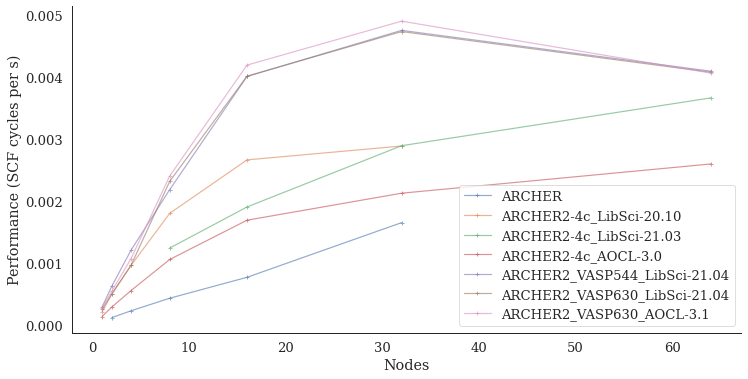

In [14]:
results = ['ARCHER','ARCHER2-4c_LibSci-20.10','ARCHER2-4c_LibSci-21.03','ARCHER2-4c_AOCL-3.0', 
           'ARCHER2_VASP544_LibSci-21.04', 'ARCHER2_VASP630_LibSci-21.04', 'ARCHER2_VASP630_AOCL-3.1']
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

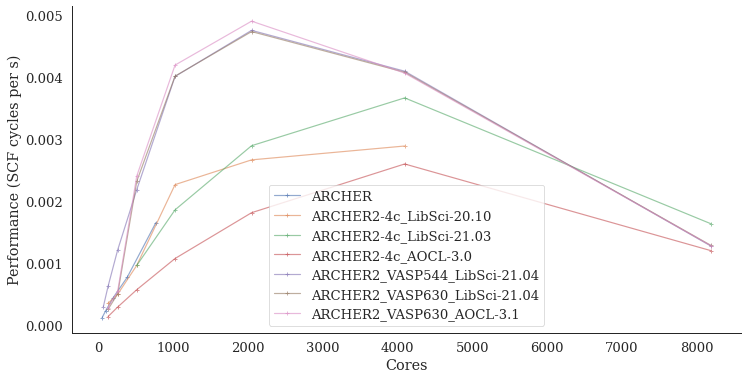

In [15]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

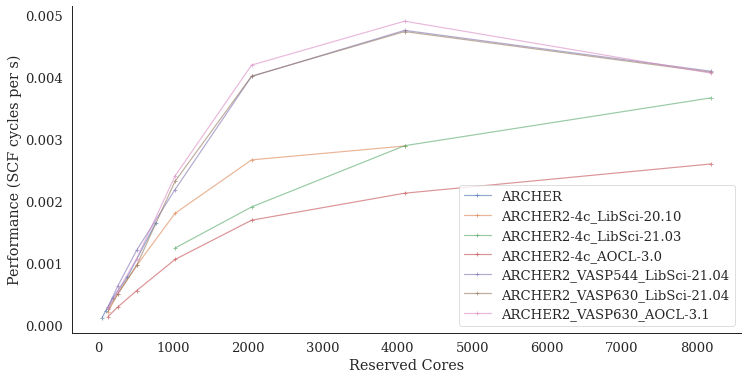

In [16]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()